# **Róbert Šafár** & **Matúš Totcimak**
## 3. fáza: *Strojové učenie*
#### Dataset 82
#### Podiel práce 50:50
#
#

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import shapiro
from sklearn.preprocessing import PowerTransformer
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer

pd.set_option('display.max_columns', None)

## Načítanie CSV súborov

In [2]:
con = pd.read_csv("dataset82/connections.csv", sep='\t')
proc = pd.read_csv("dataset82/processes.csv", sep='\t')

### Pred spojením `Connections` a `Processes` odstránime duplikátne záznamy.

In [3]:
con = con.loc[~con.duplicated()].reset_index(drop=True).copy()
proc = proc.loc[~proc.duplicated()].reset_index(drop=True).copy()

### Spojenie `Connections` a `Processes`.

In [4]:
df = pd.merge(con, proc, on=['ts', 'imei', 'mwra'])

### Overenie chýbajúcich hodnôt. Z `EDA` už vieme, že žiadne nie sú.

In [5]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

### Vymažeme atribút `imei`, pretože ho nepovažujeme za atribút, ktorý by určoval hodnotu `mwra`. Je to len identifikátor zariadení. Takisto aj `ts`.

In [6]:
df = df.drop(columns=['ts', 'imei'])

### *`Funckia:`* Zmena outlierov na hraničné hodnoty.

In [7]:
def change_outliers_iqr(df, exceptions):
    for column in df:
        if column in exceptions:
            continue
        
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

### Zmena outlierov pre všetky atribúty `df` okrem `df['c.updateassist']`.

In [8]:
df = change_outliers_iqr(df=df, exceptions=['c.updateassist'])

### Odstránenie záznamov, kde `df['c.updateassist'] >= 5`. Rovnako ako v `EDA`.

In [9]:
lines_to_remove = df[df['c.updateassist'] > 5].index
df = df.drop(lines_to_remove).copy()

In [10]:
df.shape

(14961, 31)

In [11]:
# import pandas as pd
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer
# from sklearn.feature_selection import SelectKBest, f_classif

# Define columns
yeo_johnson_columns = ['c.dogalize', 'c.android.chrome', 'c.katana', 'c.android.gm',
                       'c.android.youtube', 'c.android.vending', 'c.updateassist',
                       'p.android.packageinstaller', 'p.android.externalstorage', 'p.system',
                       'p.android.settings', 'p.android.documentsui', 'p.android.gm', 'p.katana',
                       'p.google', 'p.android.gms', 'p.inputmethod.latin']

quantile_columns = ['c.UCMobile.x86', 'c.UCMobile.intl', 'c.raider', 'p.android.chrome', 'p.process.gapps',
                    'p.olauncher', 'p.browser.provider', 'p.notifier', 'p.gms.persistent',
                    'p.android.defcontainer', 'p.android.vending', 'p.simulator', 'p.dogalize']

# Define transformers
scaler = ColumnTransformer(
    transformers=[('minmax', MinMaxScaler(), slice(1, 30))],
    remainder='passthrough',
    verbose_feature_names_out=False
)

transformer = ColumnTransformer(
    transformers=[
        ('yeo_johnson', PowerTransformer(method='yeo-johnson'), yeo_johnson_columns),
        ('quantile', QuantileTransformer(output_distribution='normal'), quantile_columns)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Define the pipeline
pipeline = Pipeline(
    steps=[
        ('transformer', transformer),
        ('scaler', scaler),
    ]
)

# Apply transformation
transformed_data = pipeline.fit_transform(df)
df = pd.DataFrame(transformed_data, columns=pipeline.get_feature_names_out())


In [12]:
# Data
X = df.drop(columns=['mwra'])

# Target
y = df[['mwra']]

In [13]:
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit_transform(X, y.values.ravel())
names = X.columns[selector.get_support()]
X = X[names]
X.shape

(14961, 10)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=0.2)

#
# **3.1 Jednoduchý klasifikátor na základe závislosti v dátach**

#
## *A) Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň).*

In [52]:
from sklearn.tree import DecisionTreeClassifier
cld = DecisionTreeClassifier(criterion='entropy', max_depth=8)

#
## *B) Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.*

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

Dtrain = cld.fit(X_train, y_train).predict(X_train)
Dtest = cld.fit(X_train, y_train).predict(X_test)

In [54]:
accuracy_score(y_test, Dtest)

0.8853992649515536

In [55]:
precision_score(y_test, Dtest)

0.898812596799174

In [56]:
recall_score(y_test, Dtest)

0.9221398305084746

#
## *C) Zistite či Váš ID3 klasifikátor má overfit.*

In [ ]:
print("ACCURACY")
print(accuracy_score(y_train, Dtrain))
print(accuracy_score(y_test, Dtest))
print()

print("PRECISION")
print(precision_score(y_train, Dtrain))
print(precision_score(y_test, Dtest))
print()

print("RECALL")
print(recall_score(y_train, Dtrain))
print(recall_score(y_test, Dtest))

ACCURACY
0.9204545454545454
0.8853992649515536

PRECISION
0.9243172951885565
0.898812596799174

RECALL
0.9505215298208077
0.9221398305084746



#
# **3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia**

#
## *A) Na trénovanie využite jeden stromový algoritmus v scikit-learn.*

In [72]:
from sklearn.ensemble import RandomForestClassifier

clr = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth = None)

Rtrain = clr.fit(X_train, y_train.values.ravel()).predict(X_train)
Rtest = clr.fit(X_train, y_train.values.ravel()).predict(X_test)

print("ACCURACY")
print(accuracy_score(y_train, Rtrain))
print(accuracy_score(y_test, Rtest))
print()

print("PRECISION")
print(precision_score(y_train, Rtrain))
print(precision_score(y_test, Rtest))
print()

print("RECALL")
print(recall_score(y_train, Rtrain))
print(recall_score(y_test, Rtest))
print()

ACCURACY
1.0
0.9111259605746742

PRECISION
1.0
0.9193381592554292

RECALL
1.0
0.9417372881355932



#
## *B) Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.*

In [67]:
from sklearn.neighbors import KNeighborsClassifier

clk = KNeighborsClassifier()

Ktrain = clk.fit(X_train, y_train.values.ravel()).predict(X_train)
Ktest = clk.fit(X_train, y_train.values.ravel()).predict(X_test)

print("ACCURACY")
print(accuracy_score(y_train, Ktrain))
print(accuracy_score(y_test, Ktest))
print()

print("PRECISION")
print(precision_score(y_train, Ktrain))
print(precision_score(y_test, Ktest))
print()

print("RECALL")
print(recall_score(y_train, Ktrain))
print(recall_score(y_test, Ktest))
print()

ACCURACY
0.9200367647058824
0.9034413631807551

PRECISION
0.9251532142391447
0.9157566302652106

RECALL
0.948783097084782
0.9327330508474576



#
## *C) Porovnajte výsledky s ID3 z prvého kroku.*

#
## *D) Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus.*

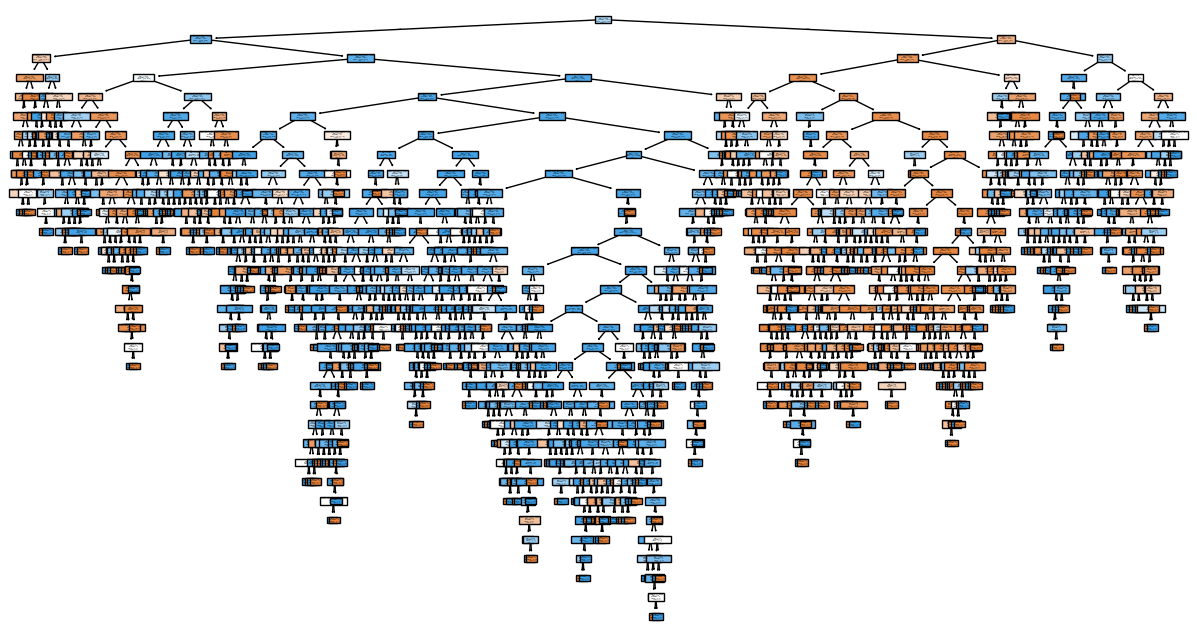

In [73]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 8))
plot_tree(clr.estimators_[0], feature_names=X.columns, class_names=['0', '1'], filled=True)
plt.show()

#
## *E) Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall.*

#
# **3.3 Optimalizácia alias hyperparameter tuning**

#
## *A) Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).*

In [74]:
from sklearn.model_selection import GridSearchCV

In [80]:
grid_param = {
    'n_estimators': [50, 100],
    'max_depth': [6, 8, 10, 12]
}

grid_search = GridSearchCV(estimator=clr, param_grid=grid_param, cv=5, scoring='accuracy')
grid_result = grid_search.fit(X_train, y_train.values.ravel())

print("Best Parameters:", grid_result.best_params_)
print("Best Cross-Validation Score:", grid_result.best_score_)

Best Parameters: {'max_depth': 12, 'n_estimators': 50}
Best Cross-Validation Score: 0.9147717461923369


#
## *B) Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).*

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [86]:
bagging = BaggingClassifier(estimator=clr, n_estimators=10, random_state=42)
bagging.fit(X_train, y_train.values.ravel())
print(bagging.score(X_test, y_test))

0.9091212829936518


#
## *C) Využite krížovú validáciu (cross validation) na trénovacej množine.*

In [88]:
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
kfold = KFold()
cv_result = cross_val_score(estimator=clr, X=X_train, y=y_train.values.ravel(), cv=kfold, scoring='accuracy')

In [92]:
print(cv_result)
print(cv_result.mean())

[0.92272348 0.91478697 0.92481203 0.91266193 0.90639365]
0.916275610324041


#
## *D) Dokážte že Váš nastavený najlepší model je bez overfitingu.*

#
# **3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu**

#
## *A) Stratégie riešenia chýbajúcich hodnôt a outlierov.*

#
## *B) Dátová transformácia (scaling, transformer, ...).*

#
## *C) Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning.*

#
## *D) Ktorý model je Váš najlepší model pre nasadenie (deployment)?*

#
## *E) Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?*